# Tabular data and MNIST Classification tutorial

This tutorial will walk you through the usage of the `stockpy` library for handling datasets and implementing machine learning algorithms for regression and classification tasks.

## Importing Required Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import stockpy
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, TraceMeanField_ELBO
import numpy as np
import matplotlib.pyplot as plt
from stockpy.neural_network import *
from stockpy.probabilistic import *

# Preparing the Dataset

We will create a synthetic dataset for classification with 10,000 samples, 20 features, and 5 classes.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, 
                           n_features=20, 
                           n_informative=15, 
                           n_redundant=5, 
                           n_classes=5, 
                           random_state=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

# Scaling Features

Scale the features to be between 0 and 1.

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)

# Callbacks for Training

Define callbacks like EarlyStopping and Learning Rate Scheduler for effective training.

In [4]:
from stockpy.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import StepLR
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=5,
    threshold=0,
    threshold_mode='rel',
    lower_is_better=True)

checkpoint = Checkpoint(
    f_params='best_model_params.pt',       # where to save the model parameters
    monitor='valid_loss_best',             # name of the variable that should be minimized
    f_optimizer='best_optimizer_params.pt',  # where to save the optimizer
    f_history='best_model_history.json',   # where to save the training history
)

# Define the LR scheduler callback
lr_scheduler = LRScheduler(policy=StepLR, step_size=10, gamma=0.7)  # Added this line

# Model Definition and Training

Define an `LSTMClassifier` model and fit it to your training data.

In [5]:
predictor = LSTMClassifier(hidden_size=512)

predictor.fit(X_train, 
              y_train, 
              batch_size=32, 
              lr=0.01, 
              optimizer=torch.optim.Adam, 
              callbacks=[early_stopping, checkpoint, lr_scheduler],
              epochs=50)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3730       0.5258        1.1540  0.5827
      2        1.1164       0.5942        1.0311  0.7677
      3        1.0257       0.6284        0.9504  0.5313
      4        0.9362       0.6474        0.9146  0.6353
      5        0.8721       0.6784        0.8223  0.6161
      6        0.8171       0.6979        0.7925  0.6471
      7        0.7769       0.7184        0.7306  0.6206
      8        0.7232       0.7489        0.6716  0.6196
      9        0.6693       0.7253        0.6930  0.6143
     10        0.6385       0.7621        0.6327  0.6856
     11        0.5595       0.7816        0.5962  0.6147
     12        0.5363       0.7853        0.5833  0.6362
     13        0.5039       0.7963        0.5463  0.6049
     14        0.4750       0.7911        0.5499  0.5952
     15        0.4448       0.8116        0.5161  0.6130
     16        0.4344       0.8

<class 'stockpy.neural_network._lstm.LSTMClassifier'>[initialized](
)

# Making Predictions and Evaluating the Model

Use the trained model to make predictions and evaluate the results using a confusion matrix.

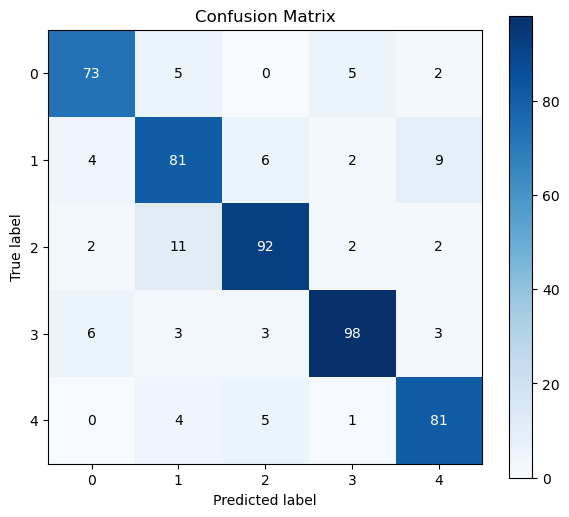

In [6]:
y_pred = predictor.predict(X_test)

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Compute the confusion matrix\n",
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Show all ticks and label them with their respective list entries\n",
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Loop over data dimensions and create text annotations\n",
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() // 2 else "black")
    plt.show()
# Assuming y_test is your true labels\n",
plot_confusion_matrix(y_test, y_pred, classes=list(map(str, np.unique(y))))  # Replace classes with your actual classes\n"

# Classification Report

Finally, generate a classification report to evaluate the model's performance.

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=list(map(str, np.unique(y)))))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        85
           1       0.78      0.79      0.79       102
           2       0.87      0.84      0.86       109
           3       0.91      0.87      0.89       113
           4       0.84      0.89      0.86        91

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



# MNIST Dataset

We will now use the MNIST dataset to train a classifier.

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0

/home/silvio/anaconda3/envs/stockpy/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

# Print a selection of training images and their labels

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

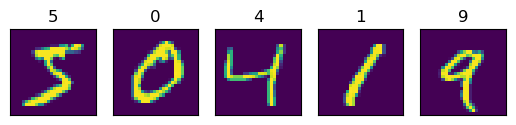

In [11]:
plot_example(X_train, y_train)

In [12]:
predictor = MLPClassifier()

predictor.fit(X_train,
              y_train,
              batch_size=32,
              lr=0.01,
              optimizer=torch.optim.Adam,
              callbacks=[early_stopping, checkpoint, lr_scheduler],
              epochs=50)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4619       0.9270        0.2507  1.8332
      2        0.3420       0.9397        0.2206  1.7397
      3        0.3172       0.9422        0.2111  1.7488
      4        0.3012       0.9430        0.2253  1.7602
      5        0.2930       0.9421        0.2151  1.8101
      6        0.2878       0.9349        0.2528  1.6842
      7        0.2774       0.9456        0.2117  1.7094
      8        0.2757       0.9424        0.2313  1.6749
Stopping since valid_loss has not improved in the last 5 epochs.


<class 'stockpy.neural_network._mlp.MLPClassifier'>[initialized](
)

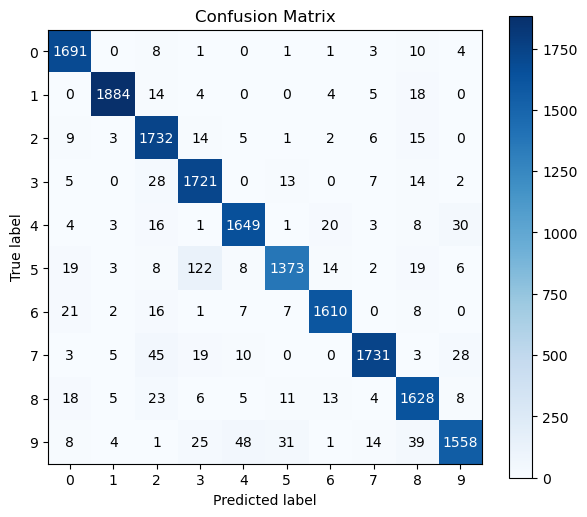

In [13]:
y_pred = predictor.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes=list(map(str, np.unique(y))))

In [14]:
print(classification_report(y_test, y_pred, target_names=list(map(str, np.unique(y)))))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1719
           1       0.99      0.98      0.98      1929
           2       0.92      0.97      0.94      1787
           3       0.90      0.96      0.93      1790
           4       0.95      0.95      0.95      1735
           5       0.95      0.87      0.91      1574
           6       0.97      0.96      0.96      1672
           7       0.98      0.94      0.96      1844
           8       0.92      0.95      0.93      1721
           9       0.95      0.90      0.93      1729

    accuracy                           0.95     17500
   macro avg       0.95      0.95      0.95     17500
weighted avg       0.95      0.95      0.95     17500

